In time step 0, 2 new satellites were launched, total nodes = 1010 

In time step 5, 2 new satellites were launched, total nodes = 1049 

In time step 10, 2 new satellites were launched, total nodes = 1090 

In time step 15, 2 new satellites were launched, total nodes = 1146 

In time step 20, 2 new satellites were launched, total nodes = 1188 

In time step 25, 2 new satellites were launched, total nodes = 1253 

In time step 30, 2 new satellites were launched, total nodes = 1326 

In time step 35, 2 new satellites were launched, total nodes = 1405 

In time step 40, 2 new satellites were launched, total nodes = 1499 

In time step 45, 2 new satellites were launched, total nodes = 1619 

In time step 50, 2 new satellites were launched, total nodes = 1733 

In time step 55, 2 new satellites were launched, total nodes = 1863 

In time step 60, 2 new satellites were launched, total nodes = 2009 

In time step 65, 2 new satellites were launched, total nodes = 2171 

In time step 70, 2 new

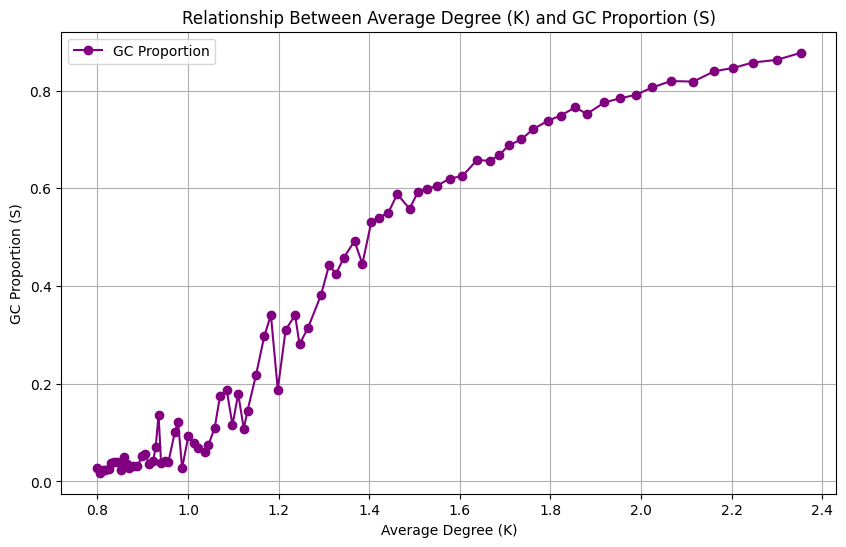

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from network.network import dynamic_network_model

# initial parameters
N = 1000  # nodes
P = 0.0008  # collision probability
plow = 0.01 # probability of generating new fragments
new_fragments_per_collision = 2  # debris per collision 
iterations = 100  # number of iterations, time steps
launch_freq = 5 # determines after how many timesteps a satellite is launched
nr_sat_launches = 2 # number of satellites launched

# # genreate a probability list from 0.001 to 0.0009
# probabilities = np.linspace(0.0001, 0.0009, 10)

# # static data
# static_network_model(N, probabilities)

# dynamic network over time
# Initialize the network
G = nx.empty_graph(N)
avg_degrees, gc_proportions, satellites_launched = dynamic_network_model(
    G, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq)

print(len(satellites_launched))
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(avg_degrees, gc_proportions, marker='o', color='purple', label='GC Proportion')
plt.title("Relationship Between Average Degree (K) and GC Proportion (S)")
plt.xlabel("Average Degree (K)")
plt.ylabel("GC Proportion (S)")
plt.grid(True)
plt.legend()
plt.show()


Running simulation 1/10...
In time step 0, 2 new satellites were launched, total nodes = 1012 

In time step 5, 2 new satellites were launched, total nodes = 1052 

In time step 10, 2 new satellites were launched, total nodes = 1110 

In time step 15, 2 new satellites were launched, total nodes = 1173 

In time step 20, 2 new satellites were launched, total nodes = 1230 

In time step 25, 2 new satellites were launched, total nodes = 1294 

In time step 30, 2 new satellites were launched, total nodes = 1372 

In time step 35, 2 new satellites were launched, total nodes = 1467 

In time step 40, 2 new satellites were launched, total nodes = 1550 

In time step 45, 2 new satellites were launched, total nodes = 1651 

In time step 50, 2 new satellites were launched, total nodes = 1762 

In time step 55, 2 new satellites were launched, total nodes = 1890 

In time step 60, 2 new satellites were launched, total nodes = 2047 

In time step 65, 2 new satellites were launched, total nodes = 22

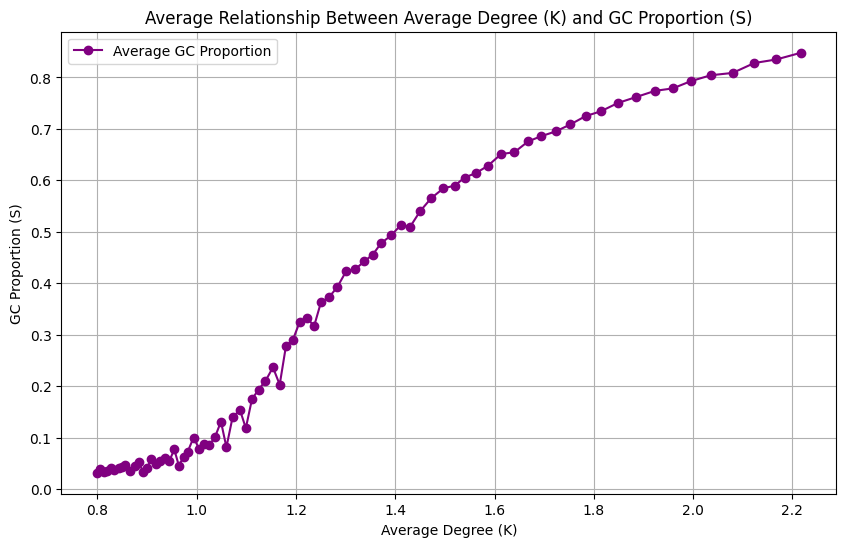

In [8]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model
import networkx as nx
import numpy as np

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch
num_simulations = 10  # Number of simulations to run

# Initialize lists to collect results across simulations
all_avg_degrees = []
all_gc_proportions = []

for sim in range(num_simulations):
    print(f"Running simulation {sim + 1}/{num_simulations}...")
    
    # Initialize the network for each simulation
    G = nx.empty_graph(N)
    
    # Run the simulation
    avg_degrees, gc_proportions, satellites_launched = dynamic_network_model(
        G, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq)
    
    # Truncate or pad to ensure consistent length
    min_length = min(len(avg_degrees), len(gc_proportions), iterations)
    avg_degrees = avg_degrees[:min_length]
    gc_proportions = gc_proportions[:min_length]
    
    # Append results (padded or truncated)
    all_avg_degrees.append(avg_degrees)
    all_gc_proportions.append(gc_proportions)

# Convert lists to numpy arrays and pad to the maximum length
max_length = min([len(seq) for seq in all_avg_degrees])
all_avg_degrees = np.array([seq[:max_length] for seq in all_avg_degrees])
all_gc_proportions = np.array([seq[:max_length] for seq in all_gc_proportions])

# Compute the average values across simulations
average_degrees = np.mean(all_avg_degrees, axis=0)
average_gc_proportions = np.mean(all_gc_proportions, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_degrees, average_gc_proportions, marker='o', color='purple', label='Average GC Proportion')
plt.title("Average Relationship Between Average Degree (K) and GC Proportion (S)")
plt.xlabel("Average Degree (K)")
plt.ylabel("GC Proportion (S)")
plt.grid(True)
plt.legend()
plt.show()


In time step 0, 2 new satellites were launched, total nodes = 1007 

In time step 5, 2 new satellites were launched, total nodes = 1044 

In time step 10, 2 new satellites were launched, total nodes = 1085 

In time step 15, 2 new satellites were launched, total nodes = 1125 

In time step 20, 2 new satellites were launched, total nodes = 1172 

In time step 25, 2 new satellites were launched, total nodes = 1227 

In time step 30, 2 new satellites were launched, total nodes = 1293 

In time step 35, 2 new satellites were launched, total nodes = 1368 

In time step 40, 2 new satellites were launched, total nodes = 1449 

In time step 45, 2 new satellites were launched, total nodes = 1533 

In time step 50, 2 new satellites were launched, total nodes = 1636 

In time step 55, 2 new satellites were launched, total nodes = 1770 

In time step 60, 2 new satellites were launched, total nodes = 1887 

In time step 65, 2 new satellites were launched, total nodes = 2026 

In time step 70, 2 new

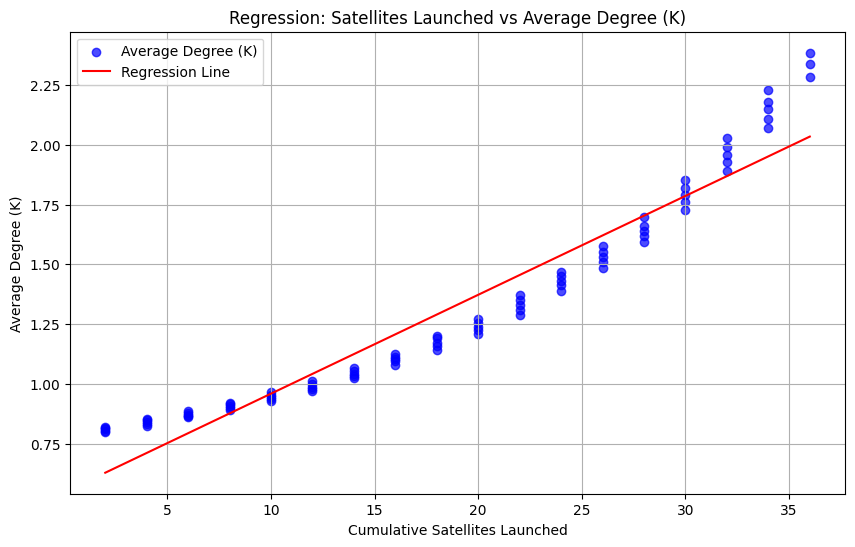

In [4]:
import matplotlib.pyplot as plt
from network.network import dynamic_network_model, satellite_launch
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Parameters
N = 1000  # Initial number of nodes
P = 0.0008  # Collision probability
plow = 0.01  # Probability of generating new fragments
new_fragments_per_collision = 2  # Debris per collision
iterations = 100  # Number of time steps
launch_freq = 5  # Launch satellites every 5 time steps
nr_sat_launches = 2  # Number of satellites launched per launch

# Initialize the network
G = nx.empty_graph(N)

# Run the dynamic network model
avg_degrees, gc_proportions, satellites_launched = dynamic_network_model(
    G, iterations, P, plow, new_fragments_per_collision, nr_sat_launches, launch_freq
)

# Check lengths of returned lists
print(f"Length of avg_degrees: {len(avg_degrees)}")
print(f"Length of gc_proportions: {len(gc_proportions)}")
print(f"Length of satellites_launched: {len(satellites_launched)}")

# Ensure all lists have consistent lengths
min_length = min(len(avg_degrees), len(gc_proportions), len(satellites_launched))
avg_degrees = avg_degrees[:min_length]
gc_proportions = gc_proportions[:min_length]
satellites_launched = satellites_launched[:min_length]

# Prepare data for regression
X = np.array(satellites_launched).reshape(-1, 1)  # Independent variable: Cumulative Satellites Launched
y = np.array(avg_degrees)  # Dependent variable: Average Degree

# Perform linear regression
regressor = LinearRegression()
regressor.fit(X, y)

# Regression results
y_pred = regressor.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print regression results
print(f"Regression Coefficients (Slope): {regressor.coef_[0]}")
print(f"Intercept: {regressor.intercept_}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualize regression results
plt.figure(figsize=(10, 6))
plt.scatter(satellites_launched, avg_degrees, color='blue', label='Average Degree (K)', alpha=0.7)
plt.plot(satellites_launched, y_pred, color='red', label='Regression Line')
plt.title("Regression: Satellites Launched vs Average Degree (K)")
plt.xlabel("Cumulative Satellites Launched")
plt.ylabel("Average Degree (K)")
plt.grid(True)
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1018.
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           5.43e-48
Time:                        17:06:08   Log-Likelihood:                 60.838
No. Observations:                  84   AIC:                            -117.7
Df Residuals:                      82   BIC:                            -112.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5666      0.027     20.923      0.0

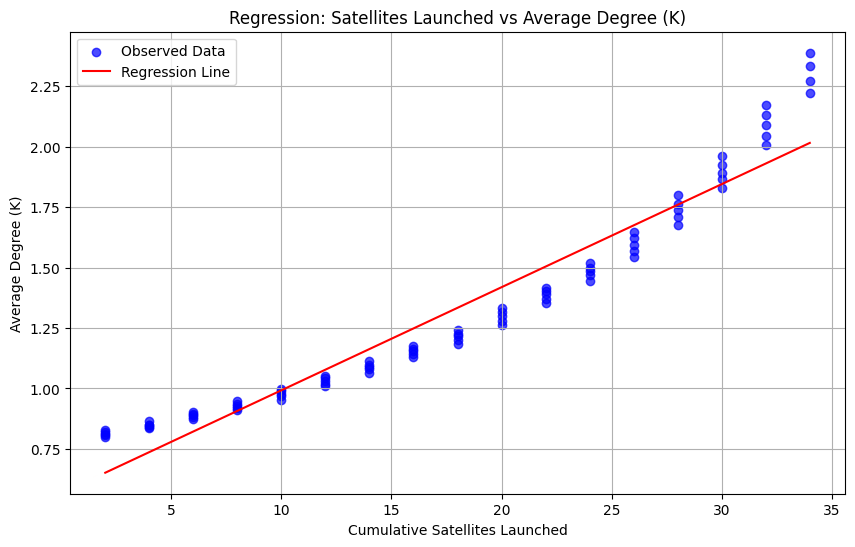

In [9]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for regression
X = np.array(satellites_launched)  # Independent variable: Cumulative Satellites Launched
y = np.array(avg_degrees)  # Dependent variable: Average Degree (K)

# Add a constant to the independent variable for the intercept
X_sm = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_sm).fit()

# Print the regression summary
print(model.summary())

# Predicted values
y_pred = model.predict(X_sm)

# Visualize the regression
plt.figure(figsize=(10, 6))
plt.scatter(satellites_launched, avg_degrees, color='blue', alpha=0.7, label='Observed Data')
plt.plot(satellites_launched, y_pred, color='red', label='Regression Line')
plt.title("Regression: Satellites Launched vs Average Degree (K)")
plt.xlabel("Cumulative Satellites Launched")
plt.ylabel("Average Degree (K)")
plt.grid(True)
plt.legend()
plt.show()


In [2]:
!which statsmodels

statsmodels not found
